In [3]:
# Import necessary libraries/modules
from scipy.io import netcdf
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from matplotlib.animation import FuncAnimation
from IPython import display
from global_land_mask import globe

# Import modules for image processing
from scipy import ndimage
import cv2


In [7]:
# Load cloud data from a netCDF file
data = nc.Dataset('C:/Users/Guillem/Desktop/^/McGill/Climate Physics/Final Project/code/13-14-15-vels-clouds.nc')
print(data.variables.keys())

# Extract different cloud cover variables and geographical data
high_clouds = data.variables['hcc'][:]
medium_clouds = data.variables['mcc'][:]
low_clouds = data.variables['lcc'][:]
lon = data.variables['longitude'][:]
lat = data.variables['latitude'][:]
time = data.variables['time'][:]

clouds = np.array([high_clouds, medium_clouds , low_clouds])

dict_keys(['longitude', 'latitude', 'time', 'hcc', 'lcc', 'mcc'])


In [31]:
# Load velocity data from another netCDF file
data2 = nc.Dataset('C:/Users/Guillem/Desktop/^/McGill/Climate Physics/Final Project/code/13-14-15-vels-si.nc')
print(data2.variables.keys())

# Extract velocity components for different cloud layers
u_high = data2.variables['u'][:,0]
v_high = data2.variables['v'][:,0]
u_medium = data2.variables['u'][:,1]
v_medium = data2.variables['v'][:,1]
u_low = data2.variables['u'][:,2]
v_low = data2.variables['v'][:,2]

u =  np.array([u_high, u_medium , u_low])
v = np.array([v_high, v_medium , v_low])

dict_keys(['longitude', 'latitude', 'level', 'time', 'u', 'v'])


KeyboardInterrupt: 

In [12]:
# Function to downsample a heatmap
def downsample_heatmap(heatmap, factor):
    # Downsample the heatmap using ndimage.zoom
    downsampled_heatmap = ndimage.zoom(heatmap, 1/factor, order=1)
    return downsampled_heatmap

# Function to highlight isolated regions in a heatmap
def highlight_isolated_regions(heatmap, threshold_value, min_region_size):
    # Threshold the heatmap to identify high-value regions
    binary_heatmap = heatmap > threshold_value

    # Label connected components in the binary image
    labeled_array, num_features = ndimage.label(binary_heatmap)

    # Find regions with sizes smaller than min_region_size
    region_sizes = np.bincount(labeled_array.ravel())
    small_regions = np.where(region_sizes < min_region_size)[0]

    # Highlight small isolated regions in a separate mask
    isolated_regions_mask = np.isin(labeled_array, small_regions[1:])
    return labeled_array, isolated_regions_mask

In [13]:
# Get centroids of squares      
def find_centroids(heat_map):
    # Find connected components (squares) in the heat map using OpenCV functions
    _, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(heat_map))

    # Remove the background (0) label
    stats = np.delete(stats, 0, axis=0)
    centroids = np.delete(centroids, 0, axis=0)

    return centroids

# Class for tracking centroids with velocity
class CentroidTrackerWithVelocity:
    def __init__(self, max_disappeared = 1, threshold = 5):
        # Initialize object tracking variables
        self.next_object_id = 0  # ID for the next object to be registered
        self.objects = {}  # Dictionary to store object IDs and their associated centroids
        self.disappeared = {}  # Dictionary to track the number of consecutive frames an object has been absent
        self.velocities = {}  # Dictionary to store velocities of objects
        self.max_disappeared = max_disappeared  # Maximum allowed consecutive frames an object can be absent
        self.threshold = threshold  # Threshold value for centroid matching


    def register(self, centroid):
        # Register a new object by assigning it an object ID and initializing tracking variables
        self.objects[self.next_object_id] = centroid  # Store the centroid associated with the object ID
        self.disappeared[self.next_object_id] = 0  # Initialize the disappeared count for the new object
        self.velocities[self.next_object_id] = (0, 0)  # Initialize the velocity of the new object
        self.next_object_id += 1  # Increment the ID for the next object


    def deregister(self, object_id):
         # Remove an object from tracking by deleting its information from dictionaries
        del self.objects[object_id]  # Remove the object's centroid information
        del self.disappeared[object_id]  # Remove the disappeared count for the object
        del self.velocities[object_id]  # Remove the velocity information for the object


    def update_with_velocity(self, centroids, time_elapsed):
        # Update existing objects' centroids and velocities based on new centroids and time elapsed
        if len(centroids) > 0:
            if len(self.objects) == 0:
                # If there are no existing objects, register all centroids as new objects
                for centroid in centroids:
                    self.register(centroid)
            else:
                # Matching centroids between current and existing objects based on distance
                object_ids = list(self.objects.keys())
                object_centroids = np.array(list(self.objects.values()))
                # Calculate Euclidean distance between centroids
                D = np.linalg.norm(centroids[:, np.newaxis] - object_centroids, axis=2)
                rows = D.min(axis=1).argsort()
                cols = D.argmin(axis=1)[rows]

                used_rows = set()
                used_cols = set()
                # Update centroids and velocities for matched pairs
                for (row, col) in zip(rows, cols):
                    if row in used_rows or col in used_cols:
                        continue

                    object_id = object_ids[col]
                    self.objects[object_id] = centroids[row]
                    
                    # Calculate velocities using displacement and time elapsed
                    self.velocities[object_id] = ((centroids[row][0] - object_centroids[col][0]) / time_elapsed,
                                                  (centroids[row][1] - object_centroids[col][1]) / time_elapsed)
                    self.disappeared[object_id] = 0

                    used_rows.add(row)
                    used_cols.add(col)

                unused_rows = set(range(0, D.shape[0])).difference(used_rows)
                unused_cols = set(range(0, D.shape[1])).difference(used_cols)
                
                # Register new objects for unpaired centroids and deregister disappeared objects
                if D.shape[0] >= D.shape[1]:
                    for row in unused_rows:
                        self.register(centroids[row])
                else:
                    for col in unused_cols:
                        self.deregister(object_ids[col])

        # Handle disappeared objects by incrementing the disappeared count
        self.disappeared = {obj_id: self.disappeared[obj_id] + 1 for obj_id in self.objects.keys()}

        # Deregister objects that have been absent for too many frames
        for obj_id in list(self.objects.keys()):
            if self.disappeared[obj_id] > self.max_disappeared:
                self.deregister(obj_id)
        # Return updated objects and velocities
        return self.objects, self.velocities
    
ct = CentroidTrackerWithVelocity()

In [16]:
# Initial downsampling for the velocity gif

downsample_factor = 16

downsampled_highclouds = np.zeros((clouds[0].shape[0], clouds[0].shape[1] // downsample_factor, clouds[0].shape[2] // downsample_factor))
for i in range(clouds[0].shape[0]):
    downsampled_highclouds[i] = downsample_heatmap(clouds[0][i], downsample_factor)

C:\Users\Guillem\anaconda3\lib\site-packages\matplotlib\quiver.py:646: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\Guillem\anaconda3\lib\site-packages\matplotlib\quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


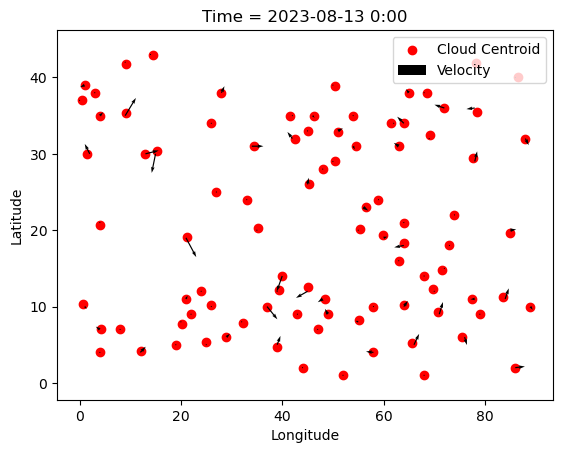

In [18]:
threshold_value = 0.9
min_region_size = 100000
# Identify and highlight isolated regions with high values
labeled_array, isolated_regions_mask = highlight_isolated_regions(downsampled_highclouds, threshold_value, min_region_size)


Figure = plt.figure()
def Animation(frames):
    
    centroids = find_centroids(isolated_regions_mask[frames])
    tracked_objects, velocity = ct.update_with_velocity(centroids, 3600)
    
    grid_size = (downsampled_highclouds.shape[1], downsampled_highclouds.shape[2])
    vector_field = np.zeros((grid_size[0], grid_size[1], 2))
    magnitude = np.linalg.norm(vector_field, axis=2)
    zero_magnitude_mask = magnitude == 0
    vector_field[zero_magnitude_mask] = np.nan
    # Fill the vector field with velocities at corresponding centroid positions
    for i in tracked_objects:
        # Extract velocities for the corresponding cloud ID
        if i in velocity:
            vel = velocity[i]
            x, y = tracked_objects[i]
            # Assign velocity components to the nearest grid position
            grid_x, grid_y = int(np.round(x)), int(np.round(y))
            vector_field[grid_y, grid_x] = vel
    plt.clf()
    if frames <= 24:
        plt.title('Time = 2023-08-13 %lg:00' % (frames))
    if frames > 24 and frames < 48:
        plt.title('Time = 2023-08-14 %lg:00' % (frames-24))
    if frames >= 48:
        plt.title('Time = 2023-08-15 %lg:00' % (frames-48))

    plt.scatter(centroids[:,0], centroids[:,1], label=f"Cloud Centroid", color='red')
    plt.quiver(vector_field[:, :, 0], vector_field[:, :, 1], label=f"Velocity")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(loc='upper right')
    
anim_created = FuncAnimation(Figure, Animation, frames = 72, interval=150)

video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html) 
# The possible warning is due to the possible zero values of velocity

In [30]:
# Define parameters
downsample_factor = 16
threshold_value = 0.9
min_region_size = 100000

# Cloud cover categories
ranges = ['high', 'medium', 'low']

# Loop through each cloud cover category to calculate each MSE and STD
for n in range(3):
    # Downsample velocity (u and v) and cloud cover data
    downsampled_u = np.zeros((u[n].shape[0], u[n].shape[1] // downsample_factor, u[n].shape[2] // downsample_factor))
    for i in range(u.shape[0]):
        downsampled_u[i] = downsample_heatmap(u[n][i], downsample_factor)

    downsampled_v = np.zeros((v[n].shape[0], v[n].shape[1] // downsample_factor, v[n].shape[2] // downsample_factor))
    for i in range(v.shape[0]):
        downsampled_v[i] = downsample_heatmap(v[n][i], downsample_factor)
        
    downsampled_clouds = np.zeros((clouds[n].shape[0], clouds[n].shape[1] // downsample_factor, clouds[n].shape[2] // downsample_factor))
    for i in range(clouds[n].shape[0]):
        downsampled_clouds[i] = downsample_heatmap(clouds[n][i], downsample_factor)
    # Highlight isolated regions in the downsampled cloud cover
    labeled_array, isolated_regions_mask = highlight_isolated_regions(downsampled_clouds, threshold_value, min_region_size)
        
    r_land = 0
    r_ocean = 0
    r = 0
    # Generate downsampled latitude and longitude arrays
    downsampled_lat = np.linspace(-90, 90, downsampled_u.shape[1], dtype = int)
    downsampled_lon = np.linspace(-180, 180, downsampled_u.shape[2], dtype = int)

    # List to store error values
    e = []

    # Loop through frames (72 frames in this case)
    for t in range(72):
        # Find centroids of isolated regions
        centroids = find_centroids(isolated_regions_mask[t])
        tracked_objects, velocity = ct.update_with_velocity(centroids, 3600)

        # Update object centroids and velocities
        grid_size = (downsampled_u.shape[1], downsampled_u.shape[2])
        vector_field = np.zeros((grid_size[0], grid_size[1], 2))

        # Fill the vector field with velocities at corresponding centroid positions
        for i in tracked_objects:
            # Extract velocities for the corresponding cloud ID
            if i in velocity:
                vel = velocity[i]
                x, y = tracked_objects[i]
                # Assign velocity components to the nearest grid position
                grid_x, grid_y = int(np.round(x)), int(np.round(y))
                vector_field[grid_y, grid_x] = vel

        a_land = 0
        a_ocean = 0
        l = 1
        o = 1
        a = 0
        conersion_factor = [50000, 20000, 11000]

        vector_field_real = np.stack((downsampled_u[t], downsampled_v[t]), axis=2)
        
        # Calculate Mean Squared Error (MSE) for land and ocean
        for i in range(vector_field.shape[0]):
            for j in range(vector_field.shape[1]):
                if np.linalg.norm(vector_field[i,j]) != 0.0:
                    if globe.is_land(downsampled_lat[i], downsampled_lon[j]) == True:
                        a_land = a_land + (vector_field[i,j]*2*conersion_factor[n] - vector_field_real[i,j])**2
                        l = l + 1
                    else:
                        a_ocean = a_ocean + (vector_field[i,j]*2*conersion_factor[n] - vector_field_real[i,j])**2
                        o = o +1
                    a = a + (vector_field[i,j]*2*conersion_factor[n] - vector_field_real[i,j])**2
                    e.append((vector_field[i,j]*2*conersion_factor[n] - vector_field_real[i,j]))

        r_land = r_land + a_land/l
        r_ocean = r_ocean + a_ocean/o
        r = r + a/(l + o)
        
    # Print Mean Squared Error (MSE) and Standard Deviation (STD) for land, ocean, and total
    print('The Land MSE for {} is: {}' .format(ranges[n],r_land/len(e)))
    print('The Ocean MSE for {} is: {}' .format(ranges[n],r_ocean/len(e)))
    print('The Total MSE for {} is: {}' .format(ranges[n], r/len(e)))
    print('The Total STD for {} is: {}' .format(ranges[n],np.std(e)))  


The Land MSE for high is: [16.75600467  8.63388565]
The Ocean MSE for high is: [15.53926528 10.70209677]
The Total MSE for high is: [15.9636264  10.03479126]
The Total STD for high is: 25.563090042914833
The Land MSE for medium is: [4.37504992 2.68092855]
The Ocean MSE for medium is: [3.44496459 2.42844952]
The Total MSE for medium is: [3.73094857 2.51023043]
The Total STD for medium is: 11.351036868039659
The Land MSE for low is: [2.80933519 2.5077446 ]
The Ocean MSE for low is: [4.65955401 3.56494984]
The Total MSE for low is: [3.96419916 3.21684876]
The Total STD for low is: 9.427278699925957
